In [1]:
import anndata as ad

# PATH = '/home/ec2-user/cell_census/tabula_sapiens__sample_single_cell__label_cell_type__processed.h5ad'
PATH = '/home/ec2-user/cell_census/tabula_sapiens__sample_donor_id__label_cell_type.h5ad'

adata = ad.read_h5ad(PATH)

from enformer_pytorch import GenomeIntervalDataset

class MyGenomeIntervalDataset(GenomeIntervalDataset):
    def __init__(self, **kwargs):
        super(MyGenomeIntervalDataset, self).__init__(**kwargs)

    def __getitem__(self, ind):
        item = super().__getitem__(ind)
        label = self.df.row(ind)[4]
        return label, item


import torch
import polars as pl
import zarr
from enformer_pytorch import Enformer
from torch.utils.data import DataLoader
from tqdm import tqdm
import pyfaidx
from pathlib import Path

torch.multiprocessing.freeze_support()

BASE_PT = "/home/ec2-user/enformer"
DEVICE = "cuda:0"

# BASE_PT = "/Users/nsofroniew/Documents/data/multiomics/enformer"
# DEVICE = "cpu"

FASTA_PT = BASE_PT + "/Homo_sapiens.GRCh38.dna.toplevel.fa"
GENE_INTERVALS_PT = BASE_PT + "/Homo_sapiens.GRCh38.genes.bed"
EMBEDDING_PT = BASE_PT + "/Homo_sapiens.GRCh38.genes.enformer_embeddings.zarr"
EMBEDDING_PT_TSS = BASE_PT + "/Homo_sapiens.GRCh38.genes.enformer_embeddings_tss.zarr"
MODEL_PT = "EleutherAI/enformer-official-rough"

def filter_df_fn(df):
    return df.filter(pl.col("column_5").is_in(list(adata.var_names)))

print("Converting fasta file")
pyfaidx.Faidx(FASTA_PT)
print("Fasta file done")

model = Enformer.from_pretrained(MODEL_PT, output_heads=dict(human = 5313), use_checkpointing = False)
model.to(DEVICE)

ds = MyGenomeIntervalDataset(
    bed_file=GENE_INTERVALS_PT,  # bed file - columns 0, 1, 2 must be <chromosome>, <start position>, <end position>
    fasta_file=FASTA_PT,  # path to fasta file
    return_seq_indices=False,  # return nucleotide indices (ACGTN) or one hot encodings
    rc_aug=False,
    shift_augs=(1, 1),
    filter_df_fn=filter_df_fn,
)
dl = DataLoader(ds, batch_size=2, shuffle=False, num_workers=0) # type: DataLoader

# Create zarr files
SEQ_EMBED_DIM = 896
EMBED_DIM = 3072
NUM_GENES = len(ds)
TSS = int(SEQ_EMBED_DIM // 2)

paths = (Path(EMBEDDING_PT), Path(EMBEDDING_PT_TSS))

Converting fasta file
Fasta file done


Some weights of the model checkpoint at EleutherAI/enformer-official-rough were not used when initializing Enformer: ['_heads.mouse.0.bias', '_heads.mouse.0.weight']
- This IS expected if you are initializing Enformer from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Enformer from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [94]:
from random import randrange

In [95]:
randrange(40245, 2)

ValueError: empty range for randrange() (40245, 2, -40243)

In [2]:
ds[181]

ValueError: empty range for randrange() (40245, 2, -40243)

In [15]:
ds.df = ds.df.with_columns([
    (pl.col("column_2") + 1),
    (pl.col("column_3") + 1),
])

In [16]:
ds.df

column_1,column_2,column_3,column_4,column_5
str,i64,i64,str,str
"""X""",100528806,100725414,"""-""","""ENSG0000000000..."
"""X""",100486499,100683107,"""+""","""ENSG0000000000..."
"""20""",50836564,51033172,"""-""","""ENSG0000000041..."
"""1""",169751328,169947936,"""-""","""ENSG0000000045..."
"""1""",169563704,169760312,"""+""","""ENSG0000000046..."
"""1""",27513761,27710369,"""-""","""ENSG0000000093..."
"""1""",196553575,196750183,"""+""","""ENSG0000000097..."
"""6""",143396508,143593116,"""-""","""ENSG0000000103..."
"""6""",53399038,53595646,"""-""","""ENSG0000000108..."


In [2]:
import pandas as pd
import numpy as np

# targets_txt = 'https://raw.githubusercontent.com/calico/basenji/0.5/manuscripts/cross2020/targets_human.txt'
# df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets = pd.read_csv(BASE_PT + '/targets_human.txt')
df_targets.shape  # (5313, 8) With rows match output shape above.
cage_indices = np.where(df_targets['description'].str.startswith('CAGE:'))[0]

In [3]:
# z_embedding_full = zarr.open(
#     EMBEDDING_PT,
#     mode="w",
#     shape=(NUM_GENES, SEQ_EMBED_DIM, EMBED_DIM),
#     chunks=(1, SEQ_EMBED_DIM, EMBED_DIM),
#     dtype='float32',
# )

# z_embedding_tss = zarr.open(
#     EMBEDDING_PT_TSS,
#     mode="w",
#     shape=(NUM_GENES, EMBED_DIM),
#     chunks=(1, EMBED_DIM),
#     dtype='float32',
# )

# index = 0
# for labels, batch in tqdm(dl):
#     # calculate embedding
#     with torch.no_grad():
#         output, embeddings = model(batch.to(DEVICE), return_embeddings=True)
#         embeddings = embeddings.detach().cpu().numpy()

#     tss_embedding = embeddings[:, TSS]

#     # save full and reduced embeddings
#     batch_size = len(embeddings)
#     z_embedding_full[index : index + batch_size] = embeddings
#     z_embedding_tss[index : index + batch_size] = tss_embedding
#     index += batch_size

In [91]:
labels, batch = next(iter(dl))

In [92]:
batch[0, :10, :]

tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

In [89]:
batch[0, :10, :]

tensor([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]])

In [50]:
with torch.no_grad():
    output, embeddings = model(batch.to(DEVICE), return_embeddings=True)
    cage_expression = output['human'][:, :, cage_indices].mean(dim=-1)
    max_inds = torch.argmax(cage_expression, dim=-1)
    batch_size = len(embeddings)
    tss_embedding = embeddings[torch.arange(batch_size), max_inds]

In [44]:
max_inds

tensor([523, 853], device='cuda:0')

In [51]:
tss_embedding.shape

torch.Size([2, 3072])

In [45]:
result = embeddings[torch.arange(2), :, max_inds]


In [47]:
result.shape

torch.Size([2, 896])

In [28]:
a

tensor([[523],
        [853]], device='cuda:0')

In [25]:
cage_expression.shape

torch.Size([2, 896])

In [185]:
label, seq = ds[20]

In [186]:
seq

tensor([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]])

In [213]:
with torch.no_grad():
    output, embeddings = model(seq.to(DEVICE), return_embeddings=True)
    cage_expression = output['human'][:, cage_indices].mean(dim=1)
    max_ind = torch.argmax(cage_expression)
    tss_embedding = embeddings[max_ind]

In [217]:
embeddings.shape

torch.Size([896, 3072])

In [212]:
max_ind = torch.argmax(cage_expression)

tensor(746, device='cuda:0')

In [215]:
tss_embedding.shape

torch.Size([3072])

In [188]:
embeddings.shape

torch.Size([896, 3072])

In [189]:
output['human'].shape

torch.Size([896, 5313])

In [190]:
import matplotlib.pyplot as plt

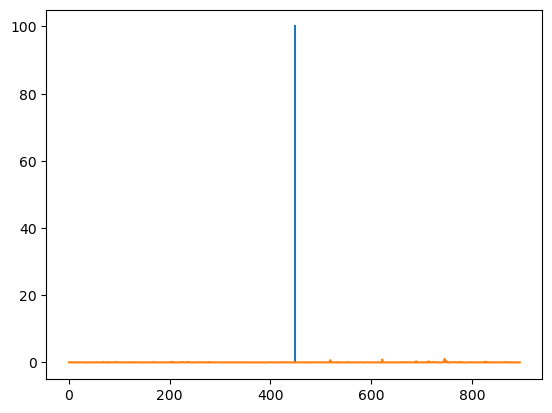

In [193]:
plt.plot([TSS, TSS], [0, 100]);
plt.plot(output['human'][:, cage_indices].mean(dim=1).cpu());

In [194]:
# !pip install pyensembl

In [195]:
# from pyensembl import Genome

# gtf_file_path = BASE_PT + '/Homo_sapiens.GRCh38.77.gtf'

# genome = Genome(reference_name='GRCh38',
#     annotation_name='my_genome_features',
#     gtf_path_or_url=gtf_file_path)
# # genome.index()

In [196]:
label

'ENSG00000002079'

In [197]:
gene = genome.gene_by_id(label)

# Observed and predicted gene expression values were obtained by summing up the observed/predicted CAGE read counts
# at all unique TSS locations of the gene. For each TSS location, we used the 128-bp bin overlapping the TSS as well
# as the two neighboring bins (3 bins in total).

# For each gene, look through all transcipts - protein coding / not, and record offsets from gene start
gene.transcripts

[Transcript(transcript_id='ENST00000439784', transcript_name='MYH16-001', gene_id='ENSG00000002079', biotype='unitary_pseudogene', contig='7', start=99238794, end=99311130, strand='+', genome='GRCh38'),
 Transcript(transcript_id='ENST00000453194', transcript_name='MYH16-002', gene_id='ENSG00000002079', biotype='processed_transcript', contig='7', start=99238911, end=99258156, strand='+', genome='GRCh38'),
 Transcript(transcript_id='ENST00000413734', transcript_name='MYH16-003', gene_id='ENSG00000002079', biotype='processed_transcript', contig='7', start=99258210, end=99261636, strand='+', genome='GRCh38'),
 Transcript(transcript_id='ENST00000425880', transcript_name='MYH16-004', gene_id='ENSG00000002079', biotype='processed_transcript', contig='7', start=99264267, end=99271049, strand='+', genome='GRCh38'),
 Transcript(transcript_id='ENST00000452010', transcript_name='MYH16-005', gene_id='ENSG00000002079', biotype='processed_transcript', contig='7', start=99297912, end=99301804, strand=

In [203]:
start_diffs = [TSS + np.round((ts.start - gene.start) / 128) for ts in gene.transcripts]

(0.0, 20.0)

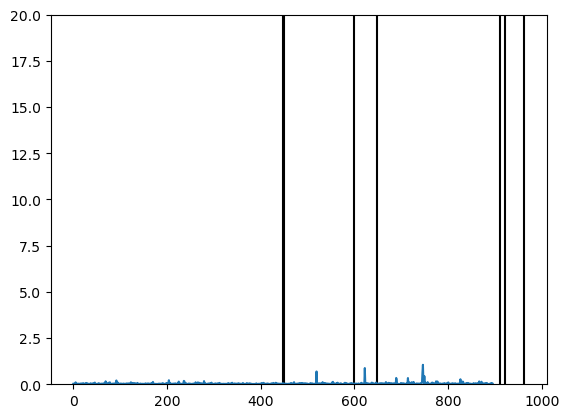

In [204]:
for st in start_diffs:
    plt.plot([st, st], [0, 100], color='k');
plt.plot(output['human'][:, cage_indices].mean(dim=1).cpu());
plt.ylim([0, 20])

In [200]:
start_diffs

[448.0, 449.0, 600.0, 647.0, 910.0, 922.0, 962.0]